<font size=6><b>
 Histopathologic Cancer Detection Project    
 -NaiJi Zhai
</b></font>

link to github repo: https://github.com/StevenGerrard8/-Histopathologic-Cancer-Detection-Project

<b>
The goal of this project is to build a cnn model that will compete at a Histopathologic Cancer Detection Competition on Kaggle,the train and test set each contains 220,025 and 57,458 96*96*3 photos that shows a screenshot from the  random human tissue sections
<b>

References:

https://www.kaggle.com/code/bonhart/pytorch-cnn-from-scratch for the model.                             
https://www.kaggle.com/code/berkealtiparmak/utmist-workshop-3/notebook for data visualization.

<b>import labraries<b>


In [1]:
import os
from glob import glob 
import time
import numpy as np  
import pandas as pd  
import cv2  
import random
import matplotlib.pyplot as plt  
from tqdm import tqdm_notebook,trange  # to see the progress
import gc #garbage collection to save RAM
%matplotlib inline  
from sklearn.model_selection import train_test_split 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')#use gpu to accelerate the model

In [3]:
train_path = "train/"
test_path = "test/"
labels=pd.read_csv("train_labels.csv")
sample_submission=pd.read_csv("sample_submission.csv")
Train,val=train_test_split(labels, stratify=labels.label, test_size=0.1)
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0]) # keep only the file names in 'id'
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head()

,path,id,label
0,train\00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,train\000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,train\00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,train\0000d563d5cfafc4e68acb7c9829258a298d9b6a...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,train\0000da768d06b879e5754c43e2298ce48726f722...,0000da768d06b879e5754c43e2298ce48726f722,1


<b>show random sample photos<b>

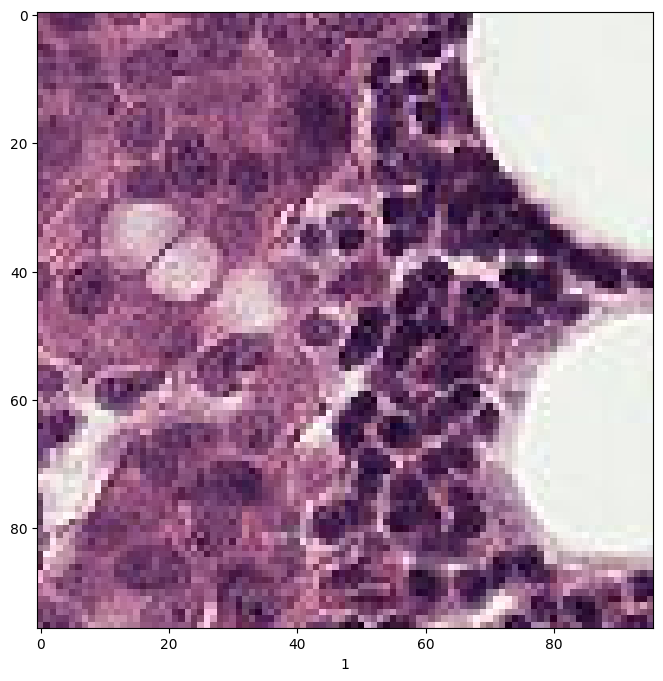

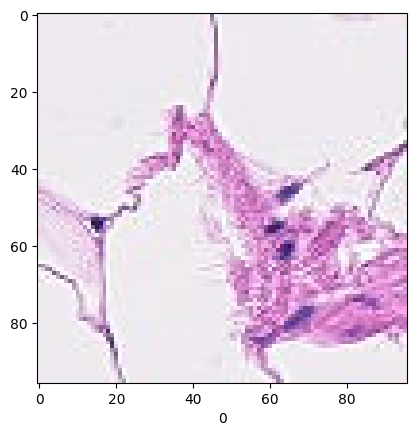

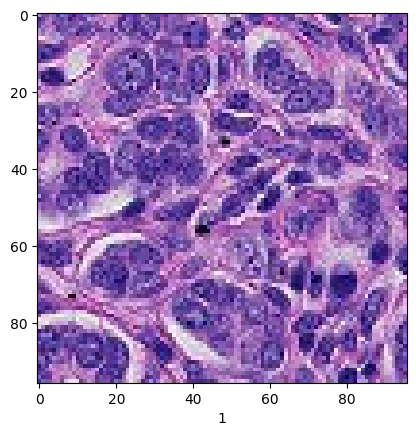

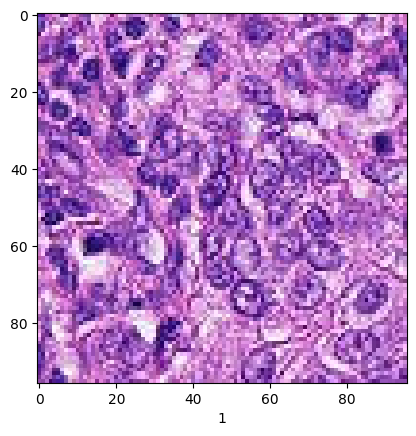

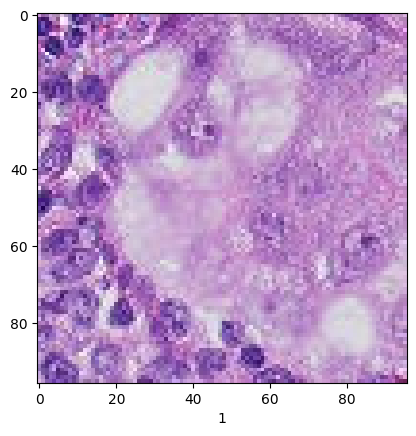

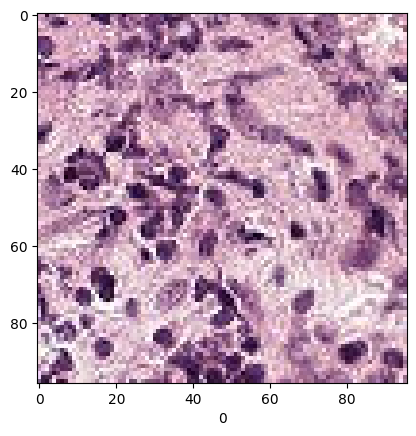

In [4]:
fig = plt.figure(figsize=(8, 8))
for _ in range(6):
    rn=np.random.randint(0, 1000, 1)
    filename = str(df['id'].iloc[rn]) 
    filename = filename.split()[1]+'.tif'
    photo = plt.imread(train_path+filename)
    label=df.label.iloc[rn]
    plt.imshow(photo)
    plt.xlabel(str(label).split()[1])# 1 means cancer and 0 for non cancer
    plt.show()

<b>now, let's see how much positive and negetive data  is there<b>

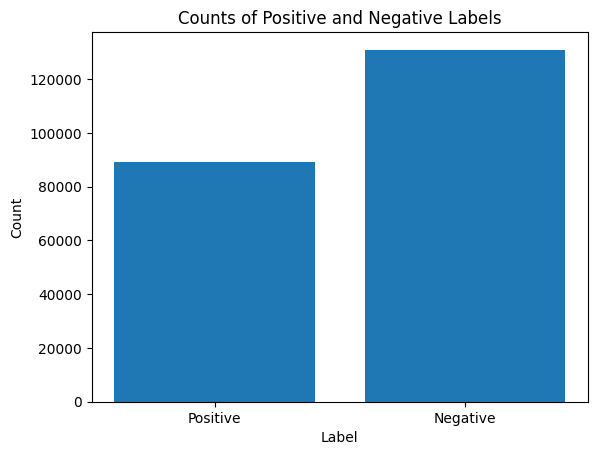

In [5]:
pos_cnt=sum(1 for i in range(len(df.label)) if df.label[i]==1)
neg_cnt=sum(1 for i in range(len(df.label)) if df.label[i]==0)
plt.bar(['Positive', 'Negative'], [pos_cnt, neg_cnt])
plt.title('Counts of Positive and Negative Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

<b>Now let us see if there is any difference between  average in 3 layers of the photo(R,G,B) for the two labels<b>

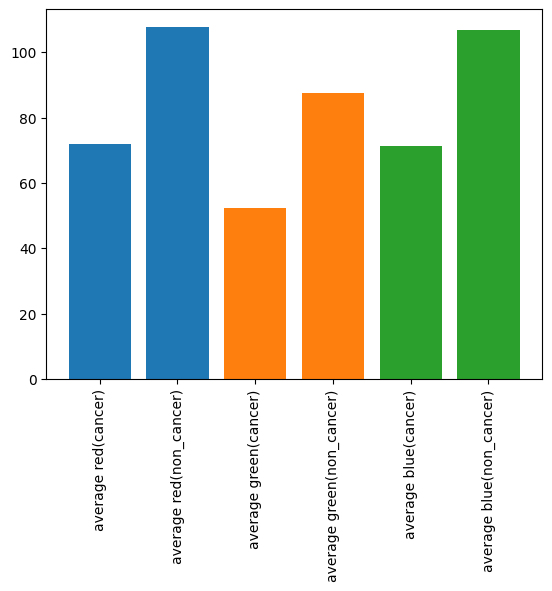

In [6]:
avg_r_non_cancer=0
avg_r_cancer=0
avg_g_non_cancer=0
avg_g_cancer=0
avg_b_non_cancer=0
avg_b_cancer=0
rnd=random.sample(range(0, 100000), 5000)
for i in rnd:
    filename=train_path+str(df['id'].iloc[i])+'.tif'
    photo=plt.imread(filename)
    if df['label'][i]==1:
        avg_r_cancer += np.mean(photo[:,:,0])
        avg_g_cancer += np.mean(photo[:,:,1])
        avg_b_cancer += np.mean(photo[:,:,2])
    else:
        avg_r_non_cancer += np.mean(photo[:,:,0])
        avg_g_non_cancer+= np.mean(photo[:,:,1])
        avg_b_non_cancer+= np.mean(photo[:,:,2])
avg_r_cancer/=5000
avg_g_cancer/=5000
avg_b_cancer/=5000
avg_r_non_cancer/=5000
avg_g_non_cancer/=5000
avg_b_non_cancer/=5000
plt.bar(['average red(cancer)', 'average red(non_cancer)'], [avg_r_cancer, avg_r_non_cancer])
plt.bar(['average green(cancer)', 'average green(non_cancer)'], [avg_g_cancer, avg_g_non_cancer])
plt.bar(['average blue(cancer)', 'average blue(non_cancer)'], [avg_b_cancer, avg_b_non_cancer])
plt.xticks(rotation='vertical')
plt.show()

<b>from the photo above, we notice that there is a huge difference lies in different channels of photo between the cancer datapoint and non_cancer data points,maybe this problem is reletively easy? Let's figure it out,but firstly we need to preprocess our photos<b>

In [7]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Pad(64, padding_mode="reflect"),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]) 
])

#transform validation data
trans_valid = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Pad(64, padding_mode="reflect"),
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]) 
])

In [8]:
class ds(Dataset):
    def __init__(self, df_data, data_dir = None, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = self.data_dir+img_name+'.tif'
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
dataset_train = ds(Train, train_path, trans_train)
dataset_valid = ds(val, train_path, trans_valid)
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

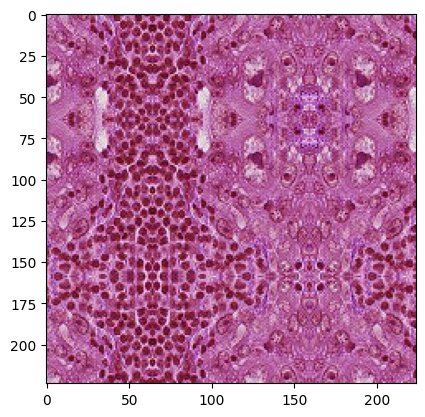

In [10]:
rand_idx = np.random.randint(0,200000,1)
image, label = dataset_train[rand_idx[0]]
plt.imshow(image.permute(1, 2, 0))
plt.show()

<b>Now, Let's build the model<b>

<b>This is the final model,,the reason I choose 7 convolution layers is that after testing from 1-12 layers, after 8 layers,the model traning time becomes rediculously long and for less than 5, the number of parameter for the mlp after convolution layer is too much(for example,50176 if we have 2 layers). As for the activation function,sigmoid works better than relu(kind of obvious since it will erase half of our image pixels) and leaky_relu<b>

In [64]:
res={}

In [141]:
class SimpleCNN(nn.Module):#final model
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=2)
        self.conv7 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=2)
        # self.conv8 = nn.Conv2d(in_channels=2048, out_channels=4096, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.bn7 = nn.BatchNorm2d(2048)
        self.bn8 = nn.BatchNorm2d(4096)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(2)
        self.fc = nn.Linear(2048 * 1 * 1, 2)
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) 
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.pool(F.leaky_relu(self.bn6(self.conv6(x))))
        x = self.pool(F.leaky_relu(self.bn7(self.conv7(x))))
        # x = self.pool(F.leaky_relu(self.bn8(self.conv8(x))))
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [142]:
#final hyperparameters:
act="leaky_relu"
num_cov=7
num_epochs = 8
num_classes = 2
batch_size = 128
learning_rate = 0.0025
gc.collect()
torch.cuda.empty_cache()

In [143]:
model = SimpleCNN().to(device)

In [144]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [145]:
total_num = 100000 #do not run this unless you have a fast computer
total_step = int(total_num/batch_size)
if total_num%batch_size != 0:
    total_step += 1 
print('total is ', total_step)

for epoch in range(num_epochs):
    step, data_count = 0, 0
    start = time.time()
    
    for images, labels in iter(loader_train):
        data_count += len(images)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (step+1) % 10 == 0:
            end = time.time()
            print("============================== step runtime from start of current epoch {} ====================================".format(end - start))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, step+1, total_step, loss.item()))
            
        step += 1
        if (data_count > total_num):
            end = time.time()
            print("============================== EPOCH RUN COMPLETED ====================================",end - start)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, step+1, total_step, loss.item()))
            break

total is  782
============================== step runtime from start of current epoch 11.742469549179077 ====================================
Epoch [1/8], Step [10/782], Loss: 0.6809
============================== step runtime from start of current epoch 20.344183921813965 ====================================
Epoch [1/8], Step [20/782], Loss: 0.5323
============================== step runtime from start of current epoch 28.860738515853882 ====================================
Epoch [1/8], Step [30/782], Loss: 0.4387
============================== step runtime from start of current epoch 37.42958068847656 ====================================
Epoch [1/8], Step [40/782], Loss: 0.4260
============================== step runtime from start of current epoch 45.96708941459656 ====================================
Epoch [1/8], Step [50/782], Loss: 0.4224
============================== step runtime from start of current epoch 54.527565002441406 ====================================
Epoch [1/8], St

In [146]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    res[(act,num_epochs,num_cov,learning_rate,batch_size)]=100 * correct / total
    print('Test Accuracy of the model on the 22003 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 22003 test images: 94.6961777939372 %


In [156]:
sub = pd.read_csv("sample_submission.csv")
dataset_valid = ds(df_data=sub, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
sub.shape, len(preds)
sub['label'] = preds
sub.to_csv('s.csv', index=False)

<font size=6><b>
Result, Analysis
</b></font>

In [155]:
res# from left to right : activation ,number of epoches,number of convolution layers,learning rate, batch_number

{('leaky_relu', 8, 7, 0.0025, 128): 94.69617779393725,
 ('leaky_relu', 8, 7, 0.0025, 256): 69.16784074898878,
 ('sigmoid', 8, 7, 0.0025, 128): 90.16784074898878,
 ('sigmoid', 8, 2, 0.0025, 128): 83.08866972685543,
 ('sigmoid', 8, 4, 0.0025, 128): 86.72685543786638,
 ('leaky_relu', 8, 4, 0.0025, 128): 75.49863333333,
 ('relu', 8, 7, 0.0025, 128): 87.5544478789563,
 ('leaky_relu', 8, 5, 0.0025, 128): 82.68356457946523,
 ('leaky_relu', 8, 6, 0.0025, 128): 88.6296548793463,
 ('leaky_relu', 8, 7, 0.002, 128): 90.63309548697904,
 ('leaky_relu', 8, 7, 0.003, 128): 92.91932723623243}

<b>As you can see from the result table above,leaky_relu works best for this problem given same other (hyper)parameters,here are some possible reason for this: Firstly,ReLUsets all negative values to zero, which can cause neurons to become inactive during training. T. Leaky ReLU addresses this by allowing a small, non-zero gradient for negative inputs, which helps prevent neurons from dying.Also, Sigmoid activation function saturates for extreme values, causing the gradient to become very small. This can lead to the vanishing gradient problem, where gradients become too small for effective learning, especially in deep networks. Leaky ReLU, by allowing non-zero gradients for negative inputs, mitigates this issue to some extent.
  As for the the learning_rate,whent the lr is too high ,the model turns to overshoot but when it is too low, the model dones't fit so well.And batch_size(see it in conclusion).<b>

<font size=6><b>
Conclusion
</b></font>

  Aftering training the cnn model,I do have a better understanding of several method taught on the class for optimize the model,for Example, early stopping, as you can see from the result table, when the number of epoches is too high, the model turns to overfit so we need to reduces it.Also, for the batch_size hyperparameter,When it is too low,each batch is a less accurate estimate of the true gradient, introducing more stochasticity into the training process. This can help the model escape local minima but might also result in more erratic training behavior.
  As for future works,Since I only have limited time for this project, I didn't go through a lot of combination of hyperparameters.So in the future I may conduct more extensive hyperparameter tuning using advanced optimization techniques like Bayesian optimization.What is more, I can experiment with more sophisticated model architectures, including state-of-the-art deep learning architectures (e.g., Transformer, EfficientNet).And, incorporate advanced regularization techniques such as mixup, label smoothing, or self-supervised learning.